<a href="https://colab.research.google.com/github/kesava2001/Deep-learning-projects/blob/main/Mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

This dataset consists of 1376 images, 690 face images with masks and 686 without masks. The original dataset is prepared by [Prajna Bhandary](https://www.linkedin.com/in/prajna-bhandary-0b03a416a/) and available at [Github](https://github.com/prajnasb/observations/tree/master/experiements/data)


In [ ]:
import cv2, os
data_path = '/content/drive/MyDrive/Colab Notebooks/Face Mask Detection/dataset'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
labels_dict = dict(zip(categories, labels))


In [ ]:
from google.colab.patches import cv2_imshow
target_size = 128
data =[]
targets =[]

for c in categories:
  folder_path = os.path.join(data_path, c)
  img_names = os.listdir(folder_path)
  for name in img_names:
    img_path = os.path.join(folder_path, name)
    img = cv2.imread(img_path)
    try:
      gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      resize = cv2.resize(gray,(target_size, target_size))
      data.append(resize)
      targets.append(labels_dict[c])
    except Exception as e:
      print('Exception:', e)

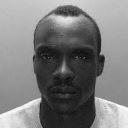

In [ ]:
cv2_imshow(data[0])

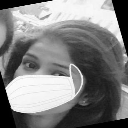

In [ ]:
cv2_imshow(resize)

In [ ]:
import numpy as np
from keras.utils import np_utils
data = np.array(data)
data = np.reshape(data, (data.shape[0], target_size, target_size, 1))
targets = np.array(targets)

Targets = np_utils.to_categorical(targets)

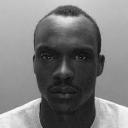

In [ ]:
cv2_imshow((data[0]))

#Training CNN

Now that we have preprocessed the data, we dive further more by training a Convolutional Neural Network for classifying a image if it has a mask or not. 

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, Targets, test_size=0.1)

In [ ]:
x_train.shape, x_test.shape

((1238, 128, 128, 1), (138, 128, 128, 1))

In [ ]:
from tensorflow import keras

model = keras.models.Sequential([
                                 keras.layers.Conv2D(200, (3,3), input_shape=(target_size, target_size, 1), activation='relu'),
                                 keras.layers.MaxPool2D(pool_size = (2,2)),

                                 keras.layers.Conv2D(100, (3,3), activation='relu'),
                                 keras.layers.MaxPool2D(pool_size = (2,2)),

                                 keras.layers.Conv2D(50, (3,3), activation='relu'),
                                 keras.layers.MaxPool2D(pool_size=(2,2)),

                                 keras.layers.Flatten(),
                                 keras.layers.Dropout(0.5),

                                 keras.layers.Dense(2048, activation='relu'),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(1024, activation='relu'),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(2, activation='softmax')

])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(data, Targets, epochs=40, validation_split=0.2)

#Accessing Web Cam in Google Colab

This code is inspired from [theAIGuys](https://github.com/theAIGuysCode/colab-webcam) code for accesing the webcam using Javascript 

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
#@title JavaScript code for Video streaming
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
#source=cv2.VideoCapture(0)

labels_dict={1:'MASK',0:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}


# start streaming video from webcam
source = video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      face_img=gray[y:y+w,x:x+w]

      resized=cv2.resize(face_img,(128,128))
      normalized=resized/255.0
      reshaped=np.reshape(normalized,(1,128,128,1))
      result=model.predict(reshaped)

      label=np.argmax(result,axis=1)[0]

      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

      cv2.putText(bbox_array, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,0,255),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>